# NN training for polarization curve with limiting current effect

This script implements a Neural Network based on TensorFlow/Keras to estimate the five parameters $(E_0, b, i_0, R, i_L)$ of an analytical polarization curve model (including mass transport limiting effect) from synthetic current-voltage data.

First, a dataset of polarization curves and corresponding parameters is loaded and split into training, validation, and test sets. The parameters are normalized to ensure stable training.

A hybrid CNN--LSTM architecture is then defined. The model is trained by minimizing the mean squared error (MSE), while the coefficient of determination $R^2$ is monitored both globally and for each parameter separately through a custom callback.

After training, the model is saved and evaluated on an independent test set. The script computes the MSE, the global and per-parameter $R^2$, and the relative errors. The predicted polarization curve is reconstructed using the analytical model and compared with the true curve. Finally, diagnostic plots are generated, showing the evolution of the loss function, parameter-wise performance, relative errors, and predicted-versus-true parameter comparisons.

# Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, LogLocator, NullFormatter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Input, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import r2_score
import random
import sys
from tensorflow.keras.regularizers import l2

# Define the analytic function of the polarization curves

In [2]:
def E(i, E0, b, i0, R, iL):
    """
    Calculate E(i) based on the given parameters with specific units.

    Parameters:
    - i: Current density (mA/cm²)
    - E0: Standard potential (V)
    - b: Tafel slope (V)
    - i0: Exchange current density (mA/cm²)
    - R: Resistance (kOhm·cm²)
    - iL: Limiting current density (mA/cm²)

    Returns:
    - E: The calculated potential (V)
    """
    
    E_tot = E0 - b * np.log(0.5 * ((i / i0) + np.sqrt((i / i0)**2 + 4))) - R * i + 1 / (i - iL)

    return E_tot

# Neural network for curves with i<sub>L</sub>

Choose the dataset, setting n_val

In [ ]:
n_val = 5

In [4]:
# Dataset upload
curves = np.load(f'curves_with_iL_{n_val}.npy')
parameters = np.load(f'params_with_iL_{n_val}.npy')

print(f"Dataset uploaded: {curves.shape[0]} curves with iL")

X = curves.copy()
y = parameters.copy()

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Splitted dataset saving
np.savez(f'dataset_split_with_iL_{n_val}.npz',
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

print(f"Training set: {X_train.shape[0]} curves")
print(f"Validation set: {X_val.shape[0]} curves")
print(f"Test set: {X_test.shape[0]} curves")


Dataset uploaded: 144624 curves with iL
Training set: 101236 curves
Validation set: 21694 curves
Test set: 21694 curves


### Normalization

Normalize the dataset: both potential and current density must be in the range of 0 and 1.

Normalize parameters between 0 and 1.

In [5]:
def normalize_curve(curve):
    min_val = np.min(curve, axis=0)
    max_val = np.max(curve, axis=0)
    return (curve - min_val) / (max_val - min_val)

curves_normalized = np.empty_like(curves)

for i in range(len(curves)):
    min_val = np.min(curves[i], axis=0)
    max_val = np.max(curves[i], axis=0)
    curves_normalized[i] = (curves[i] - min_val) / (max_val - min_val)

X_train_normalized = np.empty_like(X_train)
X_val_normalized = np.empty_like(X_val)
X_test_normalized = np.empty_like(X_test)


for i in range(len(X_train)):
    X_train_normalized[i] = normalize_curve(X_train[i])

for i in range(len(X_val)):
    X_val_normalized[i] = normalize_curve(X_val[i])

for i in range(len(X_test)):
    X_test_normalized[i] = normalize_curve(X_test[i])

# Normalize parameters
min_params, max_params = np.min(parameters, axis=0), np.max(parameters, axis=0)
parameters_normalized = (parameters - min_params) / (max_params - min_params)

# Normalize parameters in their training, validation and test set
y_train_normalized = (y_train - min_params) / (max_params - min_params)
y_val_normalized = (y_val - min_params) / (max_params - min_params)
y_test_normalized = (y_test - min_params) / (max_params - min_params)

### Dataset selection

Choose what type of data you want for training between: I-V matrix, V vector only, normalized data or not.

In [6]:
only_pot = 0 #choose type of input: 0 if input consists in i-V columns, 1 if V column only
normalization = 0 # choose type of normalization: 0 for data non normalized, 1 for data normalized

In [7]:
if only_pot == 1 and normalization == 1:                    #only normalized potential
    X_TRAIN = X_train_normalized[:, :, 1]
    X_VAL = X_val_normalized[:, :, 1]
    X_TEST = X_test_normalized[:, :, 1]
elif only_pot == 1 and normalization == 0:                  #only non-normalized potential
    X_TRAIN = X_train[:, :, 1]
    X_VAL = X_val[:, :, 1]
    X_TEST = X_test[:, :, 1]
elif only_pot == 0 and normalization == 1:                  #normalized current-potential
    X_TRAIN = X_train_normalized
    X_VAL = X_val_normalized
    X_TEST = X_test_normalized
else:                                                       #non-normalized current-potential
    X_TRAIN = X_train
    X_VAL = X_val
    X_TEST = X_test

## Built the neural network

Write R², MSE and regularization functions

In [8]:
class R2Callback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        
        # Get the number of parameters (columns) in y_train and y_val
        self.num_params = y_train.shape[1]
        
        # Initialize lists to store R² values for each parameter
        self.r2_train = {f'param_{i+1}': [] for i in range(self.num_params)}
        self.r2_val = {f'param_{i+1}': [] for i in range(self.num_params)}

    def on_epoch_end(self, epoch, logs=None):
        # Predict the parameters using the trained model. Evaluate R² globally
        y_train_pred = self.model.predict(self.X_train, verbose=0, batch_size=128)
        y_val_pred = self.model.predict(self.X_val, verbose=0, batch_size=128)

        # Compute R² globally
        r2_train = r2_score(self.y_train, y_train_pred)
        logs['r2'] = r2_train
        r2_val = r2_score(self.y_val, y_val_pred)
        logs['val_r2'] = r2_val
    
        # Compute R² for each parameter separately
        for i in range(self.num_params):
            r2_train = r2_score(self.y_train[:, i], y_train_pred[:, i])
            r2_val = r2_score(self.y_val[:, i], y_val_pred[:, i])

            # Append to the lists to track the R² values
            self.r2_train[f'param_{i+1}'].append(r2_train)
            self.r2_val[f'param_{i+1}'].append(r2_val)

            # Print the R² values to monitor training
            print(f"Epoch {epoch + 1}, Param {i + 1} - Train R²: {r2_train:.4f}, Val R²: {r2_val:.4f}")
        
        for i in range(self.num_params):
            r2_train_each_param = r2_score(self.y_train[:, i], y_train_pred[:, i])
            logs[f'r2_train_each_par{i}'] = r2_train_each_param

            r2_val_each_param = r2_score(self.y_val[:, i], y_val_pred[:, i])
            logs[f'r2_val_each_par{i}'] = r2_val_each_param


# Define R² as a custom metric Keras
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())


# Define R² and MSE for predicted parameters
def R_2(true,pred):
  R2=r2_score(true, pred)
  return(R2)

def MSE(true,pred):
   MSE = np.mean((true - pred) ** 2)
   return MSE

## Training and validation of NN

Choose if you want regularization

In [9]:
regu = 0 # 0 without regularization, 1 with regularization

lambda_reg = 0.0001 # regularization parameter

CNN+LSTM+Dense Neural Network architecture

In [10]:
# Set seed for reproducibility
seed_value = 1
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
initializer = tf.keras.initializers.GlorotNormal(seed=seed_value)

# Model without regularization
model_no_reg = Sequential([
    Input(shape=(X_train.shape[1], 2)),
    Conv1D(8, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer),
    MaxPooling1D(pool_size=2),
    Conv1D(16, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer),
    MaxPooling1D(pool_size=2),
    
    LSTM(64, activation='tanh', return_sequences=False, kernel_initializer=initializer),
    
    Dense(32, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu', kernel_initializer=initializer),
    Dropout(0.2, seed=seed_value),
    Dense(y_train_normalized.shape[1], activation='sigmoid', kernel_initializer=initializer)
])

# Model with L2 regularization
model_reg = Sequential([
    Input(shape=(X_train.shape[1], 2)),
    Conv1D(8, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    MaxPooling1D(pool_size=2),
    Conv1D(16, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    MaxPooling1D(pool_size=2),
    
    LSTM(64, activation='tanh', return_sequences=False, kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    
    Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg)),
    Dropout(0.2, seed=seed_value),
    Dense(y_train_normalized.shape[1], activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=l2(lambda_reg))
])

In [11]:
# Compile the model, using a specific loss function
if regu == 0:
    model = model_no_reg
    print("Compiling WITHOUT regularization...")
else:
    print("Compiling WITH regularization...")
    model = model_reg

model.compile(optimizer=Adam(learning_rate=0.002), loss='mse', metrics=[r2_metric])

# Instantiate the callback
r2_callback = R2Callback(X_TRAIN, y_train_normalized, X_VAL, y_val_normalized)

# Train the model minimizing the cost function, using the dedicated validation set
history = model.fit(X_TRAIN, y_train_normalized, epochs=1000, batch_size=128, validation_data=(X_VAL, y_val_normalized), verbose=0, callbacks=[r2_callback])

# Save the trained model
suffix = "regu" if regu == 1 else "noregu"
model.save(f"CNN_LSTM_{suffix}_{n_val}val_withiL.keras")

Compiling WITHOUT regularization...
Epoch 1, Param 1 - Train R²: 0.3724, Val R²: 0.3745
Epoch 1, Param 2 - Train R²: 0.2045, Val R²: 0.2001
Epoch 1, Param 3 - Train R²: 0.1341, Val R²: 0.1231
Epoch 1, Param 4 - Train R²: 0.8272, Val R²: 0.8304
Epoch 1, Param 5 - Train R²: 0.9762, Val R²: 0.9763
Epoch 2, Param 1 - Train R²: 0.5605, Val R²: 0.5617
Epoch 2, Param 2 - Train R²: 0.2732, Val R²: 0.2701
Epoch 2, Param 3 - Train R²: 0.1705, Val R²: 0.1583
Epoch 2, Param 4 - Train R²: 0.9328, Val R²: 0.9342
Epoch 2, Param 5 - Train R²: 0.9683, Val R²: 0.9682
Epoch 3, Param 1 - Train R²: 0.8468, Val R²: 0.8457
Epoch 3, Param 2 - Train R²: 0.7655, Val R²: 0.7616
Epoch 3, Param 3 - Train R²: 0.2312, Val R²: 0.2213
Epoch 3, Param 4 - Train R²: 0.9885, Val R²: 0.9887
Epoch 3, Param 5 - Train R²: 0.9911, Val R²: 0.9911
Epoch 4, Param 1 - Train R²: 0.8722, Val R²: 0.8707
Epoch 4, Param 2 - Train R²: 0.7812, Val R²: 0.7789
Epoch 4, Param 3 - Train R²: 0.2528, Val R²: 0.2447
Epoch 4, Param 4 - Train R²:

Plot training loss, global R² and R² for each parameters

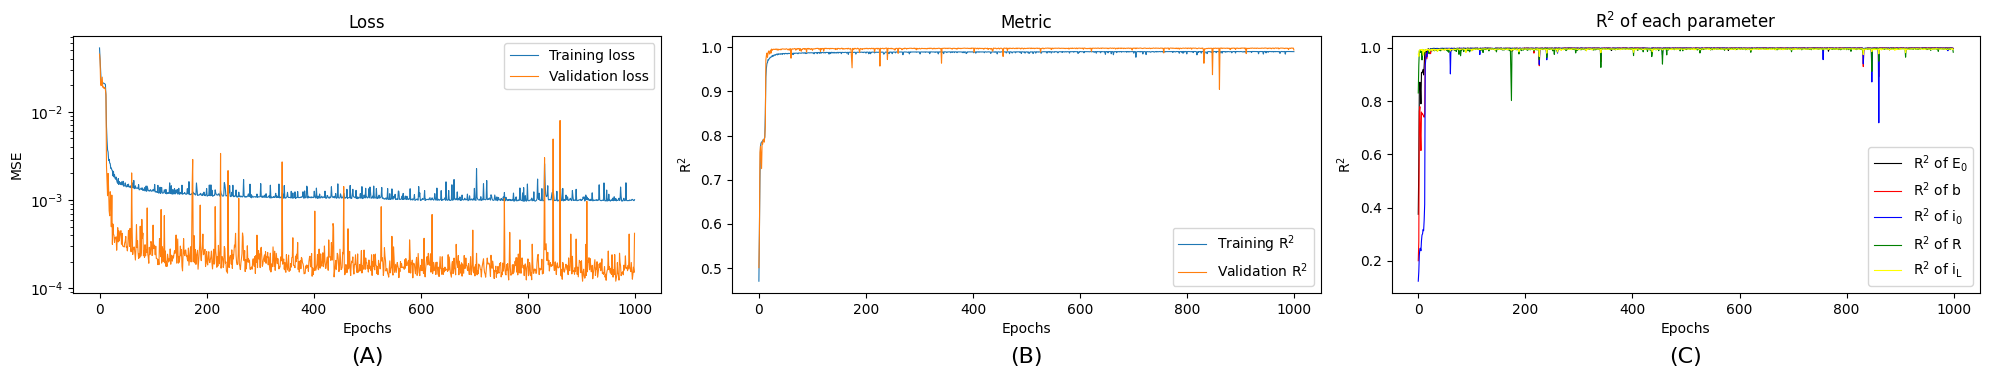

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

# Plot for training loss
axs[0].semilogy(history.history['loss'],label='Training loss', linewidth=0.8)
axs[0].semilogy(history.history['val_loss'], label='Validation loss', linewidth=0.8)
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].text(0.5, -0.25, '(A)', ha='center', va='center', transform=axs[0].transAxes, fontsize=16)  
axs[0].set_ylabel('MSE')
axs[0].legend()

# Plot R² as metrics
axs[1].plot(history.history['r2_metric'],label='Training R$^2$', linewidth=0.8)
axs[1].plot(history.history['val_r2'], label='Validation R$^2$', linewidth=0.8)
axs[1].set_title('Metric')
axs[1].set_xlabel('Epochs')
axs[1].text(0.5, -0.25, '(B)', ha='center', va='center', transform=axs[1].transAxes, fontsize=16)  
axs[1].set_ylabel('R$^2$')
axs[1].legend()

# Plot R² for each parameters
axs[2].plot(history.history['r2_val_each_par0'], c='black', label='R$^2$ of E$_0$', linewidth=0.8)
axs[2].plot(history.history['r2_val_each_par1'], c='red', label='R$^2$ of b', linewidth=0.8)
axs[2].plot(history.history['r2_val_each_par2'], c='blue', label='R$^2$ of i$_0$', linewidth=0.8)
axs[2].plot(history.history['r2_val_each_par3'], c='green', label='R$^2$ of R', linewidth=0.8)
axs[2].plot(history.history['r2_val_each_par4'], c='yellow', label='R$^2$ of i$_{\\text{L}}$', linewidth=0.8)
axs[2].set_title('R$^2$ of each parameter')
axs[2].set_xlabel('Epochs')
axs[2].text(0.5, -0.25, '(C)', ha='center', va='center', transform=axs[2].transAxes, fontsize=16)  
axs[2].set_ylabel('R$^2$')
axs[2].legend()

plt.tight_layout()
plt.savefig(f"training_CNN_LSTM_{suffix}_{n_val}val_withiL.tiff", format="tiff", dpi=300)
plt.show()

mse_train_all = history.history['loss']
mse_val_all = history.history['val_loss']

with open(f"mse_CNN_LSTM_{suffix}_all_{n_val}_withiL.txt", "w") as f:
    f.write("Epoch\tMSE_train\tMSE_val\n")
    for epoch, (m_train, m_val) in enumerate(zip(mse_train_all, mse_val_all), start=1):
        f.write(f"{epoch}\t{m_train:.6f}\t{m_val:.6f}\n")

r2_train_all = history.history['r2_metric']
r2_val_all = history.history['val_r2']

with open(f"r2_CNN_LSTM_{suffix}_all_{n_val}_withiL.txt", "w") as f:
    f.write("Epoch\tR2_train\tR2_val\n")
    for epoch, (r2_train, r2_val) in enumerate(zip(r2_train_all, r2_val_all), start=1):
        f.write(f"{epoch}\t{r2_train:.6f}\t{r2_val:.6f}\n")

Plot R² values

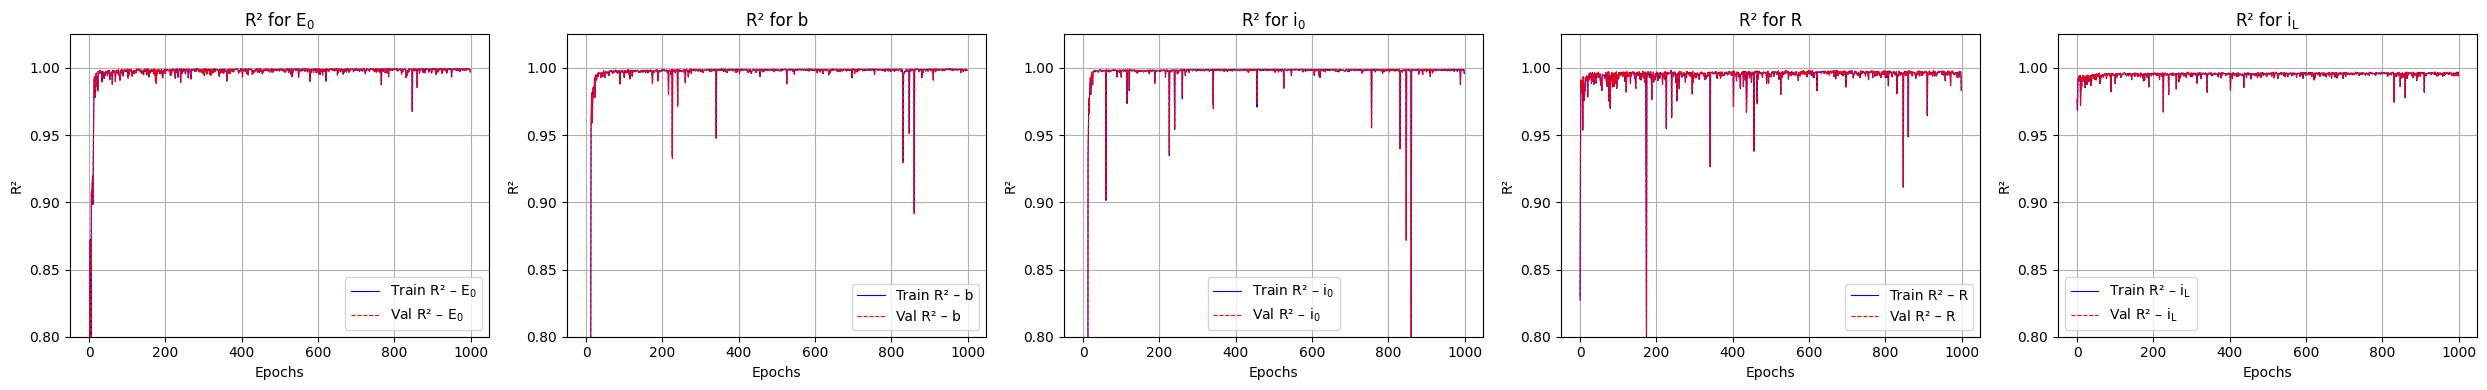

Last Train R² for E$_0$: 0.9969
Last Val   R² for E$_0$: 0.9969
Last Train R² for b: 0.9983
Last Val   R² for b: 0.9982
Last Train R² for i$_0$: 0.9958
Last Val   R² for i$_0$: 0.9958
Last Train R² for R: 0.9832
Last Val   R² for R: 0.9834
Last Train R² for i$_{\text{L}}$: 0.9941
Last Val   R² for i$_{\text{L}}$: 0.9941


In [13]:
num_params = r2_callback.num_params
param_names = ["E$_0$", "b", "i$_0$", "R", "i$_{\\text{L}}$"]

fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 4))

if num_params == 1:
    axes = [axes]

for i in range(num_params):

    key_train = f"r2_train_each_par{i}"
    key_val   = f"r2_val_each_par{i}"

    # Training curve
    axes[i].plot(history.history[key_train], label=f"Train R² – {param_names[i]}", linestyle='-', linewidth=0.8, color='b')
    # Validation curve
    axes[i].plot(history.history[key_val], label=f"Val R² – {param_names[i]}", linestyle='--', linewidth=0.8, color='r')

    # Layout
    axes[i].set_ylim(0.8, 1.025)
    axes[i].set_yticks([0.8, 0.85, 0.9, 0.95, 1])
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("R²")
    axes[i].set_title(f"R² for {param_names[i]}")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.savefig(f"r2_CNN_LSTM_{suffix}_params_{n_val}val_withiL.tiff", format="tiff", dpi=300)
plt.show()

for i in range(num_params):

    key_train = f"r2_train_each_par{i}"
    key_val   = f"r2_val_each_par{i}"
    train_vec = history.history[key_train]
    val_vec   = history.history[key_val]
    data = np.column_stack((train_vec, val_vec))

    # Saving
    with open(f"r2_CNN_LSTM_{suffix}_param_{i+1}_{n_val}val_withiL.txt", "w") as f:
        f.write(f"# Parameter {i+1}\n")
        f.write("Epoch\tTrain_R2\tVal_R2\n")
        for epoch, (tr, va) in enumerate(data):
            f.write(f"{epoch}\t{tr:.6f}\t{va:.6f}\n")

# Print last Train/Val R² for each parameter
for i in range(num_params):
    pname = param_names[i]
    print(f"Last Train R² for {pname}: {history.history[f'r2_train_each_par{i}'][-1]:.4f}")
    print(f"Last Val   R² for {pname}: {history.history[f'r2_val_each_par{i}'][-1]:.4f}")
    sys.stdout.flush()

## Test the NN using test data

In [14]:
regu = 0  # 0 without regularization, 1 with regularization

In [15]:
# Set model path automatically based on regu and n_val
if regu == 0:
    model_path = f"CNN_LSTM_noregu_{n_val}val_withiL.keras"
else:
    model_path = f"CNN_LSTM_regu_{n_val}val_withiL.keras"

# Choose the right custom_objects
if "noregu" in model_path.lower():
    print("Loading model WITHOUT regularization...")
    custom_objects = {'r2_metric': r2_metric}
    suffix = "noregu"
elif "regu" in model_path.lower():
    print("Loading model WITH regularization...")
    custom_objects = {'r2_metric': r2_metric}
    suffix = "regu"
else:
    raise ValueError("ERROR in the name of the file.")

# Loading
model = load_model(model_path, custom_objects=custom_objects)

print("Model loaded:", model_path)

Loading model WITHOUT regularization...
Model loaded: CNN_LSTM_noregu_12val_withiL.keras


In [16]:
predictions_norm = model.predict(X_TEST)

mae = MSE(y_test_normalized, predictions_norm)
R2_par0 = R_2(y_test_normalized[:,0], predictions_norm[:,0])
R2_par1 = R_2(y_test_normalized[:,1], predictions_norm[:,1])
R2_par2 = R_2(y_test_normalized[:,2], predictions_norm[:,2])
R2_par3 = R_2(y_test_normalized[:,3], predictions_norm[:,3])
R2_par4 = R_2(y_test_normalized[:,4], predictions_norm[:,4])

print('\nMSE =', mae, '\n')
print(f'R² for Test E₀ = {R2_par0}')
print(f'R² for Test b = {R2_par1}')
print(f'R² for Test i₀ = {R2_par2}')
print(f'R² for Test R = {R2_par3}')
print(f'R² for Test iₗ = {R2_par4}')

# Global R² on test set (all parameters together)
R2_global_test = r2_score(y_test_normalized, predictions_norm)
print(f"\nGlobal R²: {R2_global_test:.4f}\n")

678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

MSE = 0.0004132804973682706 

R² for Test E₀ = 0.9969708987797845
R² for Test b = 0.9983015960329571
R² for Test i₀ = 0.9957507434628627
R² for Test R = 0.9826531449009333
R² for Test iₗ = 0.9943297028443835

Global R²: 0.9936



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Parameter 1:
  Predicted        = 1.354759
  Real           = 1.351282
  Relative error = 0.26%

Parameter 2:
  Predicted        = 50.458353
  Real           = 50.314545
  Relative error = 0.29%

Parameter 3:
  Predicted        = 156.207627
  Real           = 179.491726
  Relative error = 12.97%

Parameter 4:
  Predicted        = 2.552842
  Real           = 3.269038
  Relative error = 21.91%

Parameter 5:
  Predicted        = 49.256695
  Real           = 53.377957
  Relative error = 7.72%

R² on potential values = -16.489858


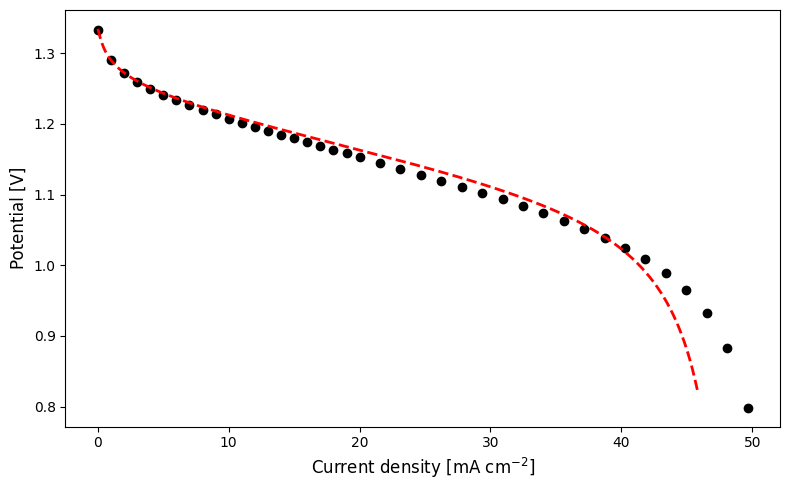

In [17]:
curve_index = 1

curve_test = X_test[curve_index]
param_test = y_test[curve_index]

curve_test = np.expand_dims(curve_test, axis=0)

pred_normalized = model.predict(curve_test)
predicted_params = pred_normalized * (max_params - min_params) + min_params

predicted_params = predicted_params.flatten()
true_params = param_test.flatten()

# Unit conversion
pred_print = predicted_params.copy()
true_print = true_params.copy()

# b -> mV/dec
pred_print[1] *= 1000 * np.log(10)
true_print[1] *= 1000 * np.log(10)

# i0 -> μA/cm²
pred_print[2] *= 1000
true_print[2] *= 1000

# R -> Ω·cm²
pred_print[3] *= 1000
true_print[3] *= 1000

relative_errors = np.abs((predicted_params - true_params) / true_params)

for i, (pred, true, err) in enumerate(zip(pred_print, true_print, relative_errors)):
    pred = float(pred)
    true = float(true)
    err = float(err)
    print(f"Parameter {i+1}:")
    print(f"  Predicted        = {pred:.6f}")
    print(f"  Real           = {true:.6f}")
    print(f"  Relative error = {err*100:.2f}%\n")

curve = curve_test[0]
i_vals = curve[:, 0]
E_real = curve[:, 1]

E0_pred, b_pred, i0_pred, R_pred, iL_pred = predicted_params

i_pred = np.linspace(0, iL_pred*0.93, 1000)
E_pred = E(i_vals, E0_pred, b_pred, i0_pred, R_pred, iL_pred)

# R^2
R2 = r2_score(E_real, E_pred)
print(f"R² on potential values = {R2:.6f}")

# Plot
E_pred= E(i_pred, E0_pred, b_pred, i0_pred, R_pred, iL_pred)
plt.figure(figsize=(8, 5))
plt.plot(i_vals, E_real, 'ko', label='Real curve')
plt.plot(i_pred, E_pred, 'r--', linewidth=2, label='Predicted curve')
plt.xlabel('Current density [mA cm$^{-2}$]', fontsize=12)
plt.ylabel('Potential [V]', fontsize=12)
#plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"curve_CNN_LSTM_{suffix}_idx_{curve_index}_withiL.tiff", format="tiff", dpi=300)
plt.show()

In [18]:
# Denormalizing parameters in order to have them in their original range
predictions = predictions_norm * (max_params - min_params) + min_params

# Relative percentage errors on the parameters
err_rel = 100*np.abs(y_test - predictions)/y_test

'''for i in range(num_params):
    print(f"min value of percentage relative error for parameter {i}: {np.min(err_rel[:,i]):.4f}")
    print(f"mean value of percentage relative error for parameter {i}: {np.mean(err_rel[:,i]):.4f}")
    print(f"max value of percentage relative error for parameter {i}: {np.max(err_rel[:,i]):.4f}\n")'''

'for i in range(num_params):\n    print(f"min value of percentage relative error for parameter {i}: {np.min(err_rel[:,i]):.4f}")\n    print(f"mean value of percentage relative error for parameter {i}: {np.mean(err_rel[:,i]):.4f}")\n    print(f"max value of percentage relative error for parameter {i}: {np.max(err_rel[:,i]):.4f}\n")'

In [19]:
r2_callback = R2Callback(X_TRAIN, y_train_normalized, X_VAL, y_val_normalized)
num_params = r2_callback.num_params  

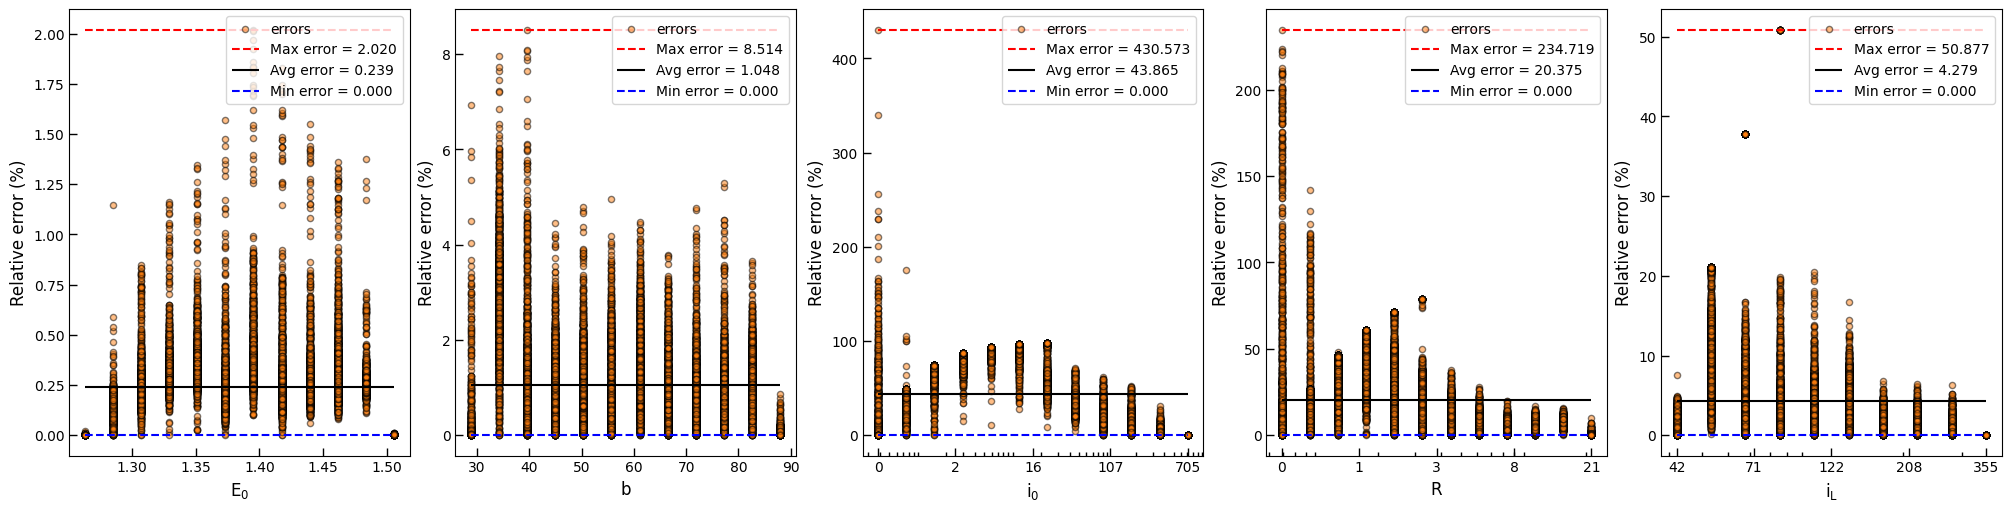

In [20]:
param_names = ["E$_0$", "b", "i$_0$", "R", "i$_{\\text{L}}$"]

fig, axs = plt.subplots(1, num_params, figsize=(4*num_params, 5), constrained_layout=True)

for i in range(num_params):
    pname = param_names[i]
    x_vals = y_test[:, i].copy()
    y_vals = err_rel[:, i].copy()

    # Scale factor
    if i == 1:  # b
        x_vals *= 1000 * np.log(10)
    elif i in [2, 3]:  # i0 and R
        x_vals *= 1000

    axs[i].scatter(x_vals, y_vals, alpha=0.5, s=20, color='tab:orange', edgecolor='k', label=f'errors')
    axs[i].hlines(np.max(y_vals), min(x_vals), max(x_vals), colors='red', linestyles='dashed', label=f'Max error = {np.max(y_vals):.3f}')
    axs[i].hlines(np.mean(y_vals), min(x_vals), max(x_vals), colors='black', linestyles='solid', label=f'Avg error = {np.mean(y_vals):.3f}')
    axs[i].hlines(np.min(y_vals), min(x_vals), max(x_vals), colors='blue', linestyles='dashed', label=f'Min error = {np.min(y_vals):.3f}')
    axs[i].set_xlabel(f'{pname}', fontsize=12)
    axs[i].set_ylabel('Relative error (%)', fontsize=12)
    axs[i].legend(fontsize=10, loc='upper right', frameon=True)
    axs[i].grid(False)

    # Log scale for i0, R, iL
    if i in [2, 3, 4]:
        axs[i].set_xscale('log')

    if i in [2, 3, 4]:
        def nice_ticks(lo, hi, num=5):
            ticks = np.logspace(np.log10(lo), np.log10(hi), num=num)
            ticks = np.round(ticks, 2)
            return ticks

        x_ticks = nice_ticks(x_vals.min(), x_vals.max())
        axs[i].xaxis.set_major_locator(FixedLocator(x_ticks))
        axs[i].xaxis.set_major_formatter(FixedFormatter([str(int(t)) for t in x_ticks]))

        # Minor tick layout
        axs[i].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=10))
        axs[i].xaxis.set_minor_formatter(NullFormatter())

    # Tick layout
    axs[i].tick_params(axis='x', which='major', direction='in', length=6, width=1)
    axs[i].tick_params(axis='y', which='major', direction='in', length=6, width=1)
    axs[i].tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    axs[i].tick_params(axis='y', which='minor', direction='in', length=3, width=1)

plt.savefig(f"test_CNN_LSTM_{suffix}_{n_val}val_withiL.png", dpi=300)
plt.show()

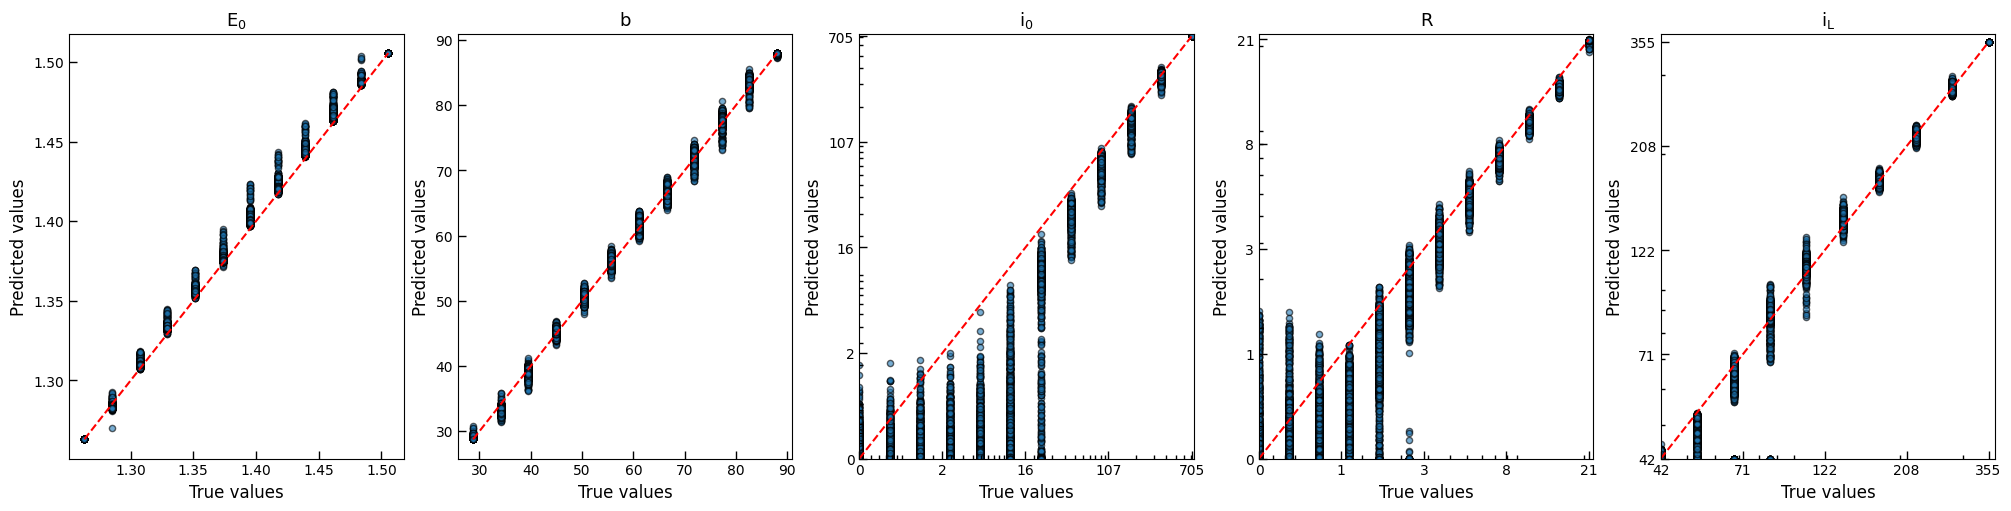

In [21]:
param_names = ["E$_0$", "b", "i$_0$", "R", "i$_{\\mathrm{L}}$"]

fig, axs = plt.subplots(1, num_params, figsize=(4*num_params, 5), constrained_layout=True)

for i in range(num_params):
    y_true_i = y_test[:, i].copy()
    y_pred_i = predictions[:, i].copy()

    # Scale factor
    if i == 1:  # b
        factor = 1000 * np.log(10)
        y_true_i *= factor
        y_pred_i *= factor
    elif i in [2, 3]:  # i0 and R
        factor = 1000
        y_true_i *= factor
        y_pred_i *= factor

    axs[i].scatter(y_true_i, y_pred_i, alpha=0.6, s=20, color='tab:blue', edgecolor='k', label='Predictions')

    min_val = min(y_true_i.min(), y_pred_i.min())
    max_val = max(y_true_i.max(), y_pred_i.max())
    margin = 0.05 * (max_val - min_val)

    # Bisector
    axs[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5)

    axs[i].set_xlabel('True values', fontsize=12)
    axs[i].set_ylabel('Predicted values', fontsize=12)
    axs[i].set_title(param_names[i], fontsize=13)
    axs[i].tick_params(axis='x', which='major', direction='in', length=6, width=1)
    axs[i].tick_params(axis='y', which='major', direction='in', length=6, width=1)
    axs[i].grid(False)

    # Log scale and personalized for subplot 3, 4, 5
    if i in [2, 3, 4]:
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')
        min_val_log = max(min_val, 1e-8)
        axs[i].set_xlim(min_val_log, max_val + margin)
        axs[i].set_ylim(min_val_log, max_val + margin)

        # Tick
        def nice_ticks(lo, hi, num=5):
            ticks = np.logspace(np.log10(lo), np.log10(hi), num=num)
            ticks = np.round(ticks, decimals=2)
            return ticks

        x_ticks = nice_ticks(min_val_log, max_val)
        y_ticks = nice_ticks(min_val_log, max_val)

        axs[i].xaxis.set_major_locator(FixedLocator(x_ticks))
        axs[i].yaxis.set_major_locator(FixedLocator(y_ticks))
        axs[i].xaxis.set_major_formatter(FixedFormatter([str(int(t)) for t in x_ticks]))
        axs[i].yaxis.set_major_formatter(FixedFormatter([str(int(t)) for t in y_ticks]))

        # Minor tick layout
        axs[i].xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=10))
        axs[i].yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=10))
        axs[i].xaxis.set_minor_formatter(NullFormatter())
        axs[i].yaxis.set_minor_formatter(NullFormatter())

        # Tick layout
        axs[i].tick_params(axis='x', which='major', direction='in', length=6, width=1)
        axs[i].tick_params(axis='y', which='major', direction='in', length=6, width=1)
        axs[i].tick_params(axis='x', which='minor', direction='in', length=3, width=1)
        axs[i].tick_params(axis='y', which='minor', direction='in', length=3, width=1)

plt.savefig(f"pred_vs_true_CNN_LSTM_{suffix}_{n_val}val_withiL.png", dpi=300)
plt.show()
